<font color='blue'> **SFR** </font><font color='orange'> **_____________________________________________________________________________________________ RUN GWF** </font> 

In [ ]:
from pathlib import Path ; import os ; import shutil    ; import matplotlib.pyplot as plt ; import numpy as np ; import pandas as pd ;
_R  = Path("./_R")       ; _R.mkdir(exist_ok=True)      ; import pyemu ; import flopy     ; import sys ; plt.rcParams['font.size'] = 14
T51   = Path("./_R/T51") ; T51.mkdir(exist_ok=True)     ; T51B   = Path("./_R/T51B")      ; T51B.mkdir(exist_ok=True)   
from modflow_devtools.misc import get_env, timed        ; import pooch ; from flopy.plot.styles import styles #; import git
write=get_env("WRITE", True);run=get_env("RUN",True);plot=get_env("PLOT",True);plot_show=get_env("PLOT_SHOW",True);plot_save=get_env("PLOT_SAVE",True);sim_name="ex-gwt-prudic2004t2" 
os.startfile('E:/15_REPOS/02_Beta-Me/Beta_xls/07_ex-gwt-prudic2004t2_b.xlsx')

In [ ]:
length_units = "feet" ;time_units = "days" ;hk = 250 ;vk = 125           ;ss = 0 ;aquifer_thickness = 120 ;porosity = 0.3 ;recharge = 0.00479  ;nlay = 8 ;nrow = 36 
LAK0 = 1 ;streambed_k = 100  ; streambed_thick = 1   ;stream_width = 5   ;manning = 0.03 ;alpha_l = 20 ;alpha_th = 2 ;alpha_tv = 0.2 ;diffc = 0 ;cstrt = 0 ;source_concentration = 500
REF1 = Path('E:/15_REPOS/02_Beta-Me/data/MF6/51')    ; ncol = 23         ;delr = 405.665 ;delc = 403.717 ;delv = 15 ;top = 100 ;total_time = 9131

F01 = "bot1.dat"      ; BO0 = np.loadtxt(REF1/F01)               ; botm = [BO0] + [BO0 - (15.0 * k) for k in range(1, nlay)]   
F02 = "idomain1.dat"  ; ID0 = np.loadtxt(REF1/F02, dtype=int)    ; idomain = nlay * [ID0]    
F03 = "lakibd.dat"    ; LB0 = np.loadtxt(REF1/F03, dtype=int)    #AA=[[1],[2],[3]] ; AA[1].append(-31) ; AA
F04 = "stream.csv"    ; dt = 5 * [int] + [float]                 ; STR = np.genfromtxt(REF1/F04, names=True, delimiter=",", dtype=dt)

In [3]:
def get_stream_data():
    SFR1 = [[IR] for IR in range(STR.shape[0])]                               ; isegold = -1                            ; SEGD = [] ; distance = 0
    for IR, row in enumerate(STR):   
        iseg = row["seg"] - 1
        if iseg == isegold:
            SFR1[IR].append(IR-1)        ; SFR1[IR-1].append(-IR)             ;distance+=(STR["length"][IR - 1] * 0.5+ STR["length"][IR] * 0.5)
        else:                              distance = 0.5 * STR["length"][IR]
        isegold = iseg                   ; SEGD.append(distance)
    SFR1[17].append(-31)                 ; SFR1[31].append(17)                ; SFR1[30].append(-31)    ; SFR1[31].append(30) 
    
    SFR2 = [] ; segment_lengths = []
    for iseg in [1, 2, 3, 4]:        idx = np.where(STR["seg"] == iseg) ; segment_length = STR["length"][idx].sum() ; segment_lengths.append(segment_length)
    emaxmin = [(49, 45), (44.5, 34), (41.5, 34.0), (34.0, 27.2)] ; segment_gradients = []
    for iseg, (emax, emin) in enumerate(emaxmin): segment_gradients.append((emax - emin) / segment_lengths[iseg])
    ustrf = 1.0 ; ndv = 0
    for IR, row in enumerate(STR):
        k,i,j = row["layer"]-1, row["row"]-1, row["col"]-1              ; length = row["length"]               ; iseg = row["seg"] - 1  ; rgrd = segment_gradients[iseg]
        emax, emin = emaxmin[iseg]          ; rtp=SEGD[IR]/segment_lengths[iseg]*(emax-emin)                   ; rtp  = emax - rtp      ; boundname = f"SEG{iseg + 1}"
        rec = (IR,(k, i, j),length,stream_width,rgrd,rtp,streambed_thick,streambed_k,manning,len(SFR1[IR]) - 1 , ustrf,ndv,boundname,)  ; SFR2.append(rec)
    return SFR2, SFR1

In [10]:
SFR1, SFR2 = get_stream_data()                ; SFRT = {0: [[0,"inflow",86400], [18,"inflow",8640.0]]}  ; PER=[["SFR-1",5,"LAK-1",0,"FACTOR",1.0] ,["LAK-1",0,"SFR-1",6,"FACTOR",1.0]]
shutil.copy(REF1 / F04, _R/'_01_stream.csv')  ; pd.DataFrame(SFR1).to_csv(_R/'_02_SFR1.csv')            ; pd.DataFrame(SFR2).to_csv(_R/'_03_SFR2.csv')
shutil.copy(REF1 / 'chd.dat', _R/'_04_chd.dat')

WindowsPath('_R/_04_chd.dat')

In [ ]:
def build_mf6gwf(SIM):
    global idomain                           ; name = "flow"      ; HED = f"{name}.hds"  ; BUD = f"{name}.bud"                  ; chdlist=[]  
    for line in open(REF1/'chd.dat').readlines(): 
        ll = line.strip().split()
        if len(ll) == 4:    
            k, i, j, hd = ll                 ; chdlist.append([(int(k)-1 ,int(i)-1 ,int(j)-1) ,float(hd)])
            
    SFRO = {(name + ".sfr.obs.csv",)  : [("reach1leakage", "SFR", "SEG1") ,("reach2leakage", "SFR", "SEG2") ,("reach3leakage","SFR","SEG3") ,("reach4leakage","SFR","SEG4")]}  # __ 4
    SFRO["digits"] = 7                ; SFRO["print_input"] = True        ;SFRO["filename"]=name+".sfr.obs"

    sim = flopy.mf6.MFSimulation (sim_name=name, sim_ws=T51/SIM/"mf6gwf", exe_name="mf6")         ; tdis_data = [(total_time, 1, 1.0)]
    flopy.mf6.ModflowTdis        (sim, nper=len(tdis_data), perioddata=tdis_data, time_units=time_units)
    flopy.mf6.ModflowIms         (sim, print_option="summary",outer_maximum=1000,inner_maximum=50,outer_dvclose=0.01,inner_dvclose=0.01,relaxation_factor=0.99,)
    gwf = flopy.mf6.ModflowGwf   (sim, modelname=name, save_flows=True)
    dis = flopy.mf6.ModflowGwfdis(gwf, length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm,idomain=idomain)
    flopy.mf6.ModflowGwfnpf      (gwf, save_specific_discharge=True,save_saturation=True,icelltype=[1] + 7 * [0],k=hk,k33=vk)
    flopy.mf6.ModflowGwfic       (gwf, strt=50.0)
    flopy.mf6.ModflowGwfoc       (gwf, head_filerecord=HED,budget_filerecord=BUD,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")],)
    flopy.mf6.ModflowGwfrcha     (gwf, recharge={0: recharge}, pname="RCH-1")
    flopy.mf6.ModflowGwfchd      (gwf, stress_period_data=chdlist, pname="CHD-1")

    idomain = dis.idomain.array          ; lake_map = np.ones((nlay, nrow, ncol), dtype=np.int32) * -1                  ; lake_map[0, :, :] = LB0[:, :] - 1
    (idomain, LAK1, LAK2) = (flopy.mf6.utils.get_lak_connections(gwf.modelgrid, lake_map, idomain=idomain, bedleak=LAK0))
    gwf.dis.idomain.set_data(idomain[0], layer=0, multiplier=[1])       ;     lakpackagedata = [[0, 44.0, LAK1[0], "lake1"],[1, 35.2, LAK1[1], "lake2"]]
    outlets = [[0, 0, -1, "MANNING", 44.5, 3.36493214532915, 0.03, 0.2187500e-02]]

    flopy.mf6.ModflowGwflak     (gwf,time_conversion=86400.000,length_conversion=3.28081,print_stage=True,print_flows=True,stage_filerecord=name+".lak.bin",budget_filerecord=name+".lak.bud",
                                mover=True,pname="LAK-1",boundnames=True,nlakes=len(lakpackagedata),noutlets=len(outlets),outlets=outlets,packagedata=lakpackagedata,connectiondata=LAK2)
    flopy.mf6.ModflowGwfsfr     (gwf,print_stage=True,print_flows=True,stage_filerecord=name + ".sfr.bin",budget_filerecord=name + ".sfr.bud",mover=True,pname="SFR-1",time_conversion=86400.000,
                                length_conversion=3.28081,boundnames=True ,nreaches=len(SFR2) ,packagedata=SFR1 ,connectiondata=SFR2 ,perioddata=SFRT,observations=SFRO)
    flopy.mf6.ModflowGwfmvr     (gwf,maxmvr=2,print_flows=True,budget_filerecord=name + ".mvr.bud",maxpackages=2,packages=[["SFR-1"], ["LAK-1"]],perioddata=PER)
    return sim

<font color='orange'> **RUN GWF _____________________________________________________________________________________________** </font> 

In [6]:
%%capture   
sim_mf6gwf = build_mf6gwf(sim_name)   ; sim_mf6gwf.write_simulation(silent='silent')      ; sim_mf6gwf.run_simulation(silent='silent', report=True)

In [7]:
def plot_bcmap(ax, gwf, layer=0):
    pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=layer)   ; pmv.plot_inactive(color_noflow="gray", alpha=0.25)    ; pmv.plot_array(LB0, masked_values=[0], alpha=0.2)
    pmv.plot_bc(name="CHD-1", color="blue")                       ; pmv.plot_bc(name="SFR-1", color="green")              ; ax.set_xlabel("x position (ft)")
    ax.set_ylabel("y position (ft)")    ; ax.set_aspect("equal")  ; return pmv

gwf = sim_mf6gwf.flow   ; head = gwf.output.head().get_data()  ; stage = gwf.lak.output.stage().get_data().flatten()

fig, axs = plt.subplots(1, 2, figsize=(6, 6), dpi=300, tight_layout=True)
for ilay in [0, 1]:
    ax = axs[ilay]  ; pmv = plot_bcmap(ax, gwf, ilay)     ; levels = np.arange(20, 60, 1)
    cs = pmv.contour_array(head,colors="blue",linestyles="-",levels=levels,masked_values=[1.0e30],) ; ax.clabel(cs, cs.levels[::5], fmt="%1.0f", colors="b")          
    title = f"Model Layer {ilay + 1}"   ; letter = chr(ord("@") + ilay + 1)   ; styles.heading(letter=letter, heading=title, ax=ax)  ; plt.close() # plt.show()

fig.savefig(_R / 'FIG1') ; os.startfile(_R / 'FIG1.png')

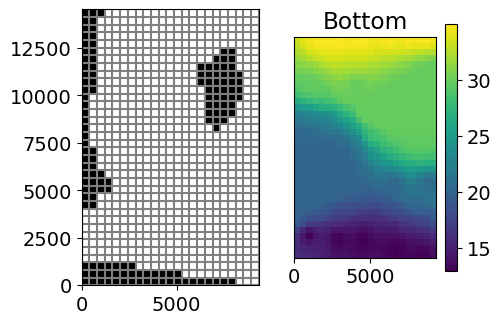

In [8]:
fig = plt.figure(figsize=(16, 4))                             
ax1 = fig.add_subplot(161) ; mm = flopy.plot.PlotMapView(model=gwf, layer=0, extent=gwf.modelgrid.extent)     ; mm.plot_grid()   ; mm.plot_ibound() 
ax2 = fig.add_subplot(162) ; pm = flopy.plot.PlotMapView(modelgrid=gwf.modelgrid) ; pc= pm.plot_array([BO0])  ; ax2.set_title('Bottom')  
ax2.yaxis.set_visible(False) ; plt.colorbar(pc, shrink=0.8) ; plt.show()